##**Assignment 2 - Deep learning for computer vision**

## Objective: To build a Convolutionary Network on a dataset which contains images of cats and dogs such that the model learns the features of these images and will be capable of classifying the unseen images(Test data) into cats & dogs effectively.

## Data source: The data set has been taken from Kaggle which contains Training and Test sets with 25000 & 12500 images of equal number of cats & dogs respectively. But, we are going to use only few images (2000) to build the model.

## 1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text. Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

#### Test Accuracy - 71.9%

#### Training Accuraccy - 98.35%

#### Validation Accuracy - 77.09%


### So, we got the above results when we used a training sample of 1000 images and using dropout to reduce overfitting.

### Downloading the data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rambabutalacheru","key":"fa59af252e0805f2ef288d17d73d607c"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:03<00:00, 248MB/s]
100% 812M/812M [00:03<00:00, 231MB/s]


In [ ]:
!unzip -qq dogs-vs-cats

In [ ]:
!unzip -qq test1.zip

In [ ]:
!unzip -qq train.zip

In [ ]:
#shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
#shutil.rmtree("./test1", ignore_errors=True)
#shutil.rmtree("./train", ignore_errors=True)


**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Create a datset instance from NumPy array of random numbers of 1000 samples and each sample of vector size 16

In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


Batching the data into batches of size 32

In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


##Building the model

**Instantiating a small convnet for dogs vs. cats classification**


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Fitting the model using a `Dataset`**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 24s 164ms/step - loss: 0.6938 - accuracy: 0.5205 - val_loss: 0.6924 - val_accuracy: 0.5020
Epoch 2/30
63/63 [==============================] - 9s 140ms/step - loss: 0.6937 - accuracy: 0.5085 - val_loss: 0.6922 - val_accuracy: 0.4990
Epoch 3/30
63/63 [==============================] - 9s 139ms/step - loss: 0.6748 - accuracy: 0.5660 - val_loss: 0.6424 - val_accuracy: 0.6260
Epoch 4/30
63/63 [==============================] - 9s 139ms/step - loss: 0.6468 - accuracy: 0.6455 - val_loss: 0.6354 - val_accuracy: 0.6390
Epoch 5/30
63/63 [==============================] - 9s 139ms/step - loss: 0.6153 - accuracy: 0.6575 - val_loss: 0.6324 - val_accuracy: 0.6470
Epoch 6/30
63/63 [==============================] - 10s 149ms/step - loss: 0.5856 - accuracy: 0.6820 - val_loss: 0.5866 - val_accuracy: 0.6880
Epoch 7/30
63/63 [==============================] - 9s 138ms/step - loss: 0.5763 - accuracy: 0.7050 - val_loss: 0.6080 - val_accuracy: 0.6790
Epoc

**Displaying curves of loss and accuracy during training**

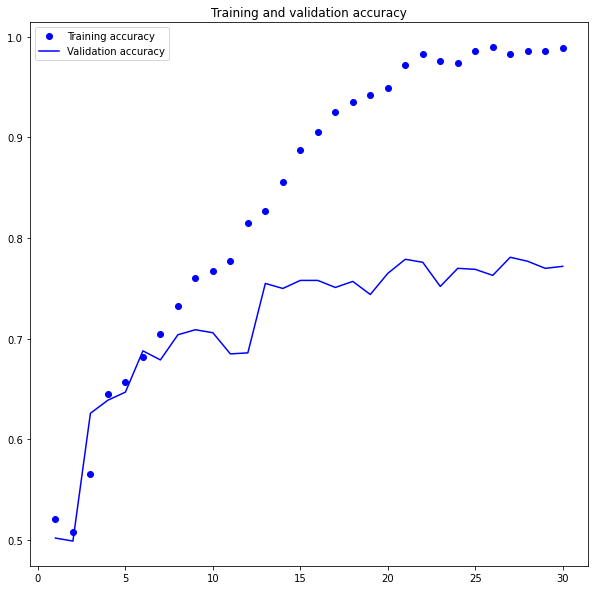

<Figure size 432x288 with 0 Axes>

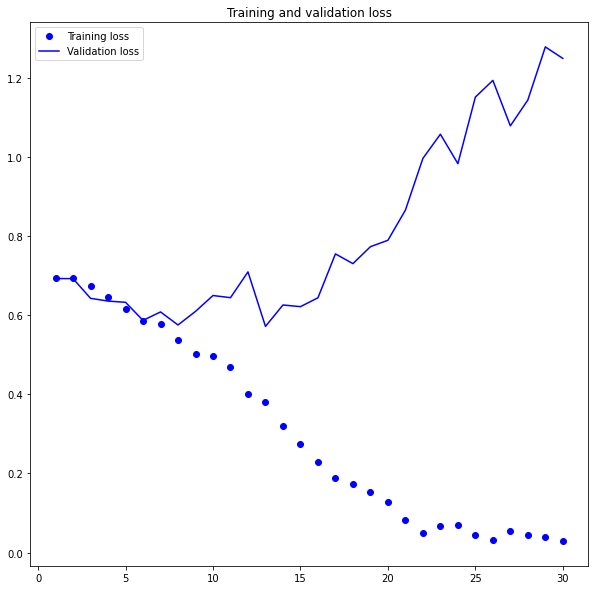

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.6798 - accuracy: 0.7190
Test accuracy: 0.719


# Q2.  Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

#### Test Accuracy - 82.70%

#### Training Accuraccy - 88%

#### Validation Accuracy - 84% 


## So, there is a high increase in  Train, Validation and Test(From 71% to 82.7%) accuracy when the number of training samples is increased and data augmentation is used as expected. 

**Define a data augmentation stage to add to an image model**

In [ ]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

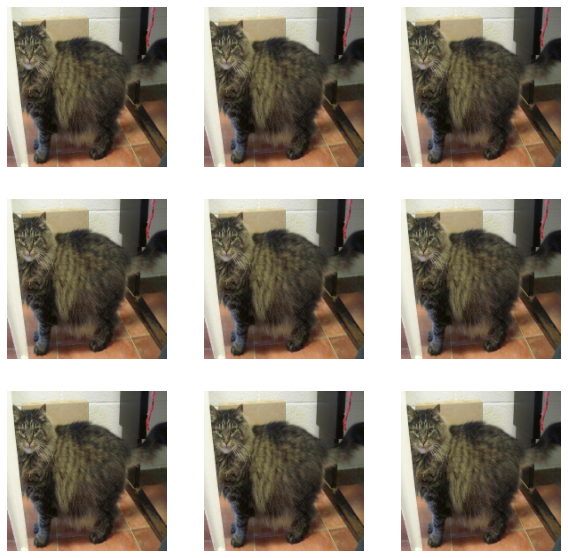

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 11s 149ms/step - loss: 0.6941 - accuracy: 0.4975 - val_loss: 0.6926 - val_accuracy: 0.5250
Epoch 2/50
63/63 [==============================] - 10s 148ms/step - loss: 0.6949 - accuracy: 0.5115 - val_loss: 0.6924 - val_accuracy: 0.5960
Epoch 3/50
63/63 [==============================] - 10s 147ms/step - loss: 0.6879 - accuracy: 0.5345 - val_loss: 0.6690 - val_accuracy: 0.5970
Epoch 4/50
63/63 [==============================] - 10s 147ms/step - loss: 0.6845 - accuracy: 0.5570 - val_loss: 0.6492 - val_accuracy: 0.6270
Epoch 5/50
63/63 [==============================] - 10s 147ms/step - loss: 0.6721 - accuracy: 0.5900 - val_loss: 0.6282 - val_accuracy: 0.6550
Epoch 6/50
63/63 [==============================] - 10s 146ms/step - loss: 0.6575 - accuracy: 0.6130 - val_loss: 0.6309 - val_accuracy: 0.6380
Epoch 7/50
63/63 [==============================] - 10s 148ms/step - loss: 0.6382 - accuracy: 0.6405 - val_loss: 0.5974 - val_accuracy: 0.6830

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.4469 - accuracy: 0.8270
Test accuracy: 0.827


# Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

# Let's increase the Training sample size to 2000 and monitor the results.

#### Test Accuracy - 80%

#### Training Accuraccy - 89%

#### Validation Accuracy - 81.20%


# So, the Validation and Test accuracy has decreased when the training sample size is increased from 1500 to 2000. The ideal training sample size is 1500 as per the above observations.






### Increasing the training sample to 2000, keeping the Validation and test sets the same as before(500 samples)

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

**Defining a new convnet with increased training samples,image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 11s 152ms/step - loss: 0.6923 - accuracy: 0.5235 - val_loss: 0.6704 - val_accuracy: 0.5660
Epoch 2/50
63/63 [==============================] - 10s 147ms/step - loss: 0.6838 - accuracy: 0.5335 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 10s 147ms/step - loss: 0.6880 - accuracy: 0.5310 - val_loss: 0.6944 - val_accuracy: 0.4710
Epoch 4/50
63/63 [==============================] - 10s 149ms/step - loss: 0.6716 - accuracy: 0.5925 - val_loss: 0.6627 - val_accuracy: 0.6060
Epoch 5/50
63/63 [==============================] - 10s 148ms/step - loss: 0.6803 - accuracy: 0.5780 - val_loss: 0.9576 - val_accuracy: 0.5210
Epoch 6/50
63/63 [==============================] - 10s 146ms/step - loss: 0.6524 - accuracy: 0.6225 - val_loss: 0.7936 - val_accuracy: 0.5630
Epoch 7/50
63/63 [==============================] - 10s 147ms/step - loss: 0.6622 - accuracy: 0.6145 - val_loss: 0.6319 - val_accuracy: 0.6280

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.4678 - accuracy: 0.8020
Test accuracy: 0.802


#Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.


## Summary

### Using a Pre-trained model without Augmentation

#### We reach a validation accuracy of about 97.30% which is better than what we achieved while training the small model from scratch. However, the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. 


### Using a Pre-trained model without Augmentation

#### A model’s accuracy always depends on the set of samples one evaluates it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets. because of this reason, Pretrained model With Augmentation, there was just a minor increase in the accuracy from 97.30% to 98.10%.



### Feature extraction with a pretrained model

#### Feature extraction means using the representations learned by a previously trained model (ImageNet, in our case) to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Feature extraction without data augmentation using a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 14ms/step - loss: 14.7583 - accuracy: 0.9280 - val_loss: 6.0208 - val_accuracy: 0.9650
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 4.2271 - accuracy: 0.9725 - val_loss: 14.2351 - val_accuracy: 0.9430
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1.8967 - accuracy: 0.9845 - val_loss: 13.4930 - val_accuracy: 0.9390
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 0.7578 - accuracy: 0.9925 - val_loss: 9.0612 - val_accuracy: 0.9620
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.8752 - accuracy: 0.9930 - val_loss: 8.0139 - val_accuracy: 0.9600
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.9456 - accuracy: 0.9920 - val_loss: 8.0784 - val_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5039 - accuracy: 0.9950 - val_loss: 5.1372 - val_accuracy: 0.9730
Epoch 8/20
63

**Plotting the results**

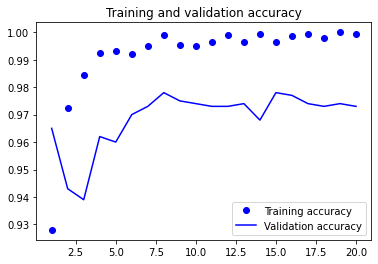

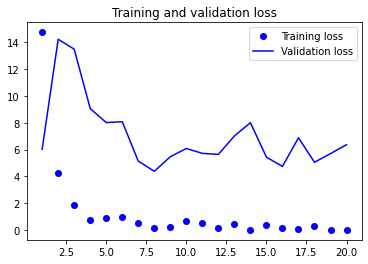

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Feature extraction with data augmentation using a pretrained model

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 29s 438ms/step - loss: 19.3596 - accuracy: 0.8930 - val_loss: 13.2364 - val_accuracy: 0.9190
Epoch 2/50
63/63 [==============================] - 27s 430ms/step - loss: 6.4584 - accuracy: 0.9465 - val_loss: 4.4460 - val_accuracy: 0.9690
Epoch 3/50
63/63 [==============================] - 27s 426ms/step - loss: 6.6738 - accuracy: 0.9500 - val_loss: 6.7322 - val_accuracy: 0.9640
Epoch 4/50
63/63 [==============================] - 27s 429ms/step - loss: 4.3443 - accuracy: 0.9650 - val_loss: 3.2013 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 27s 426ms/step - loss: 5.0478 - accuracy: 0.9590 - val_loss: 3.3833 - val_accuracy: 0.9740
Epoch 6/50
63/63 [==============================] - 27s 426ms/step - loss: 4.3858 - accuracy: 0.9600 - val_loss: 4.4004 - val_accuracy: 0.9750
Epoch 7/50
63/63 [==============================] - 27s 425ms/step - loss: 2.4976 - accuracy: 0.9740 - val_loss: 4.5388 - val_accuracy: 0.97

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 9s 270ms/step - loss: 2.0973 - accuracy: 0.9790
Test accuracy: 0.979


### A pretrained VGG16 model with Fine-tuning 

#### Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevant for the problem at hand.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 32s 474ms/step - loss: 0.2829 - accuracy: 0.9900 - val_loss: 2.0677 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 30s 470ms/step - loss: 0.5034 - accuracy: 0.9920 - val_loss: 1.7168 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - 30s 468ms/step - loss: 0.4098 - accuracy: 0.9890 - val_loss: 1.6178 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 29s 464ms/step - loss: 0.1503 - accuracy: 0.9955 - val_loss: 1.6272 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 30s 472ms/step - loss: 0.2236 - accuracy: 0.9935 - val_loss: 1.1429 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 30s 464ms/step - loss: 0.2903 - accuracy: 0.9910 - val_loss: 1.2392 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 30s 469ms/step - loss: 0.2025 - accuracy: 0.9920 - val_loss: 1.1187 - val_accuracy: 0.9790

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 9s 270ms/step - loss: 1.6916 - accuracy: 0.9810
Test accuracy: 0.981
